In [2]:
import os
import numpy as np
import pandas as pd
import json
from ast import literal_eval
import time

In [3]:
os.getcwd()

'D:\\graduate_student\\2019-2020one\\DM\\吕晓玲\\HW\\BRS'

In [4]:
####读入电影数据###
moviedata = pd.read_csv("../movies_metadata.csv")
####打印变量名称####
moviedata.columns.values

D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


array(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'id', 'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'], dtype=object)

In [5]:
####把需要的变量读入数据框当中####
data = moviedata[['genres','original_language','overview',\
                 'production_companies','production_countries',\
                'runtime','release_date','popularity','spoken_languages',\
                'vote_average','vote_count','budget','revenue','id']]
#data.head(5)###再一次查看数据

In [6]:
###输出缺失值个数
num_fea_bank  = pd.isna(data).sum()
print(num_fea_bank)

genres                    0
original_language        11
overview                954
production_companies      3
production_countries      3
runtime                 263
release_date             87
popularity                5
spoken_languages          6
vote_average              6
vote_count                6
budget                    0
revenue                   6
id                        0
dtype: int64


In [7]:
df = data.dropna().reset_index(drop = True)###删除缺失值

In [8]:
def jsontrans(df): 
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.timestamp())
    json_columns = ['genres', 'production_countries',
                    'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
    return df
df = jsontrans(df)
#df.head(5)

In [9]:
#####标记出含有[]的索引号########
list1 = list(df["production_countries"])
index = []
for i in range(len(list1)):
    if(list1[i] == []):
        index.append(i)

In [10]:
df = df.drop(index).reset_index(drop = True)###删除缺失值

In [11]:
df.shape

(38499, 14)

In [12]:
def tranSet(obj):
    n = len(obj)
    objset = set({})
    for i in range(n):
        #print(i)
        objset = objset|set(obj[i])
    return list(objset)
def dummyTrans(obj):
    genresSet = tranSet(obj)
    n = len(obj)
    temp = np.zeros(n*len(genresSet)).reshape(n,len(genresSet))
    for i in range(n):
        x = np.zeros(len(genresSet))
        x[list(map(lambda x: genresSet.index(x),obj[i]))] = 1
        if(any(x!=0)):            
            temp[i,] = x
        else:
            temp[i,] = temp[i-1,]
    temp = pd.DataFrame(temp)
    temp.columns = genresSet
    return temp

In [13]:
dfnew = dummyTrans(df['genres']).join(dummyTrans(df['production_countries'])).\
    join(dummyTrans(df['spoken_languages'])).join(df)

In [14]:
dfnew = dfnew.drop(columns=['production_companies','production_countries','spoken_languages','genres','overview','original_language'])

In [15]:
#####最后的数据结构######
dfnew.shape

(38499, 263)

### 将缺失的数据进行删除

In [16]:
def dele(df,n,m):
    df = np.array(df)
    tempa = df[(df[:,-n] != 0),:]
    tempb = tempa[tempa[:,-m] != '0',]
    return pd.DataFrame(tempb) 
dfnew = dele(dfnew,2,3)

###  数据标准化

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(dfnew.iloc[:,:-1])                               # 使用transfrom必须要用fit语句
trans_dfnew = scaler.transform(dfnew.iloc[:,:-1])          # transfrom通过找中心和缩放等实现标准化

In [18]:
trans_dfnew = pd.DataFrame(trans_dfnew) 

In [19]:
trans_dfnew['id'] = np.array(list(map(int,dfnew.iloc[:,-1])))

In [20]:
import tensorflow.compat.v1 as tf ###因为在tf2下使用了tf1的API
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


### 推荐系统网络

#### 读入数据

In [21]:
user_actor1 = pd.read_csv("user_actor_50000.csv")
text_data = pd.read_csv("newdata.csv")
movie_data = trans_dfnew
user_actor2 = pd.read_csv("score_actor.csv")
user_actor = user_actor1.append(user_actor2)

D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [22]:
textNet = text_data[['id','key_words']]####需要送入到网络中的文本
textNet = textNet.dropna(axis=0,how='any')

#### 数据处理

In [23]:
####文本处理
title_set = set()
i = 0
for val in textNet['key_words'].str.split():
    title_set.update(val)

title_set.add('<PAD>')
title2int = {val:ii for ii, val in enumerate(title_set)}

#将电影Title转成等长数字列表，长度是15
title_count = 30
title_map = {val:[title2int[row] for row in val.split()] for ii,val in enumerate(set(textNet['key_words']))}

for key in title_map:
    if (title_count > len(title_map[key])):
        for cnt in range(title_count - len(title_map[key])):
            title_map[key].insert(len(title_map[key]) + cnt,title2int['<PAD>'])
textNet['key_words']= textNet['key_words'].map(title_map)
textNet = textNet.reset_index(drop = True)
for i in range(len(textNet['key_words'])):
    textNet['key_words'][i] = textNet['key_words'][i][0:title_count]
textNet = textNet.dropna(axis=0,how='any')

In [24]:
##这里必须删掉那些日期字符，还要多删几个
textNet = textNet[textNet['id'] != '2014-01-01']
textNet = textNet[textNet['id'] != '1997-08-20']
textNet = textNet[textNet['id'] != '2012-09-29']

In [25]:
###训练数据集
textNet['id'] = list(map(int,textNet['id']))

In [26]:
trans_dfnew.columns.values[-1] = 'id'

In [27]:
user_actor['movieId'] = list(map(int,user_actor['movieId']))

In [28]:
a = user_actor['movieId'][0] 

In [46]:
####把这些数据都连起来
df = pd.merge(user_actor, trans_dfnew,how='left',left_on='movieId',right_on='id')
df = df.dropna(axis = 0).reset_index(drop = True)
df = pd.merge(df, textNet,how='left',left_on='id',right_on='id')

In [47]:
####这是最终要送到网络里的数据集
df.dropna(axis = 0).reset_index(drop = True).shape

(2790, 291)

### 拆分训练集和测试集

In [48]:
df = df.drop(columns=['userId','movieId','timestamp','id'])

In [49]:
df.columns.values####索引号1~21维用户特征，索引号21~24为演员特征，索引号24~286为电影特征，索引号为286为文本特征

array(['rating', 'Animation', 'History', 'Fantasy', 'Crime', 'Comedy',
       'TV Movie', 'Western', 'Family', 'Action', 'War', 'Mystery',
       'Music', 'Adventure', 'Drama', 'Foreign', 'Thriller', 'Horror',
       'Science Fiction', 'Documentary', 'Romance', '点度中心性', '紧密中心性',
       '介数中心性', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100,
       101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 1

In [50]:
from sklearn.model_selection import train_test_split
y = df.iloc[:,0]
X = df.iloc[:,1:]
# X['usrid'] = df['userId']
# X['movieId'] = df['movieId']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=980)
x_train = np.array(x_train.reset_index(drop=True))
x_test = np.array(x_test.reset_index(drop=True))
y_train = np.array(y_train.reset_index(drop=True))
y_test = np.array(y_test.reset_index(drop=True))

##### 先把所有样本的keywords转为序列

In [51]:
x_train_usr = x_train[:,0:20]####用户特征
x_train_actor = x_train[:,20:23]####演员特征
x_train_movie = x_train[:,23:285]####用户特征
x_train_keyword = x_train[:,285]####演员特征
x_test_usr = x_test[:,0:20]####用户特征
x_test_actor = x_test[:,20:23]####演员特征
x_test_movie = x_test[:,23:285]####用户特征
x_test_keyword = x_test[:,285]####演员特征

### 网络训练

In [52]:
#创建一个神经网络层
def add_layer(input,in_size,out_size,activation_function=None):
    """
    :param input: 数据输入
    :param in_size: 输入大小
    :param out_size: 输出大小
    :param activation_function: 激活函数（默认没有）
    :return:output：数据输出
    
    """
    Weight=tf.Variable(tf.random_normal([in_size,out_size],stddev=0.1) )
    biases=tf.Variable(tf.ones([1,out_size]) )
    W_mul_x_plus_b=tf.matmul(input,Weight) + biases
    #根据是否有激活函数
    if activation_function == None:
        output=W_mul_x_plus_b
    else:
        output=activation_function(W_mul_x_plus_b)
    return output

In [53]:
y_train = y_train.reshape(len(y_train),1)

In [54]:
x_train_usr.shape[1]

20

In [55]:
###构建网络结构############################
#####用户特征#######
p_train = x_train_usr.shape[1]
x_usr = tf.placeholder(tf.float32,[None,20])
#定义第一个隐藏层
# 激活函数为sigmoid
hidden_layer_usr1=add_layer(x_usr,20,10,activation_function=tf.nn.relu)
# #定义第二个隐藏层
hidden_layer_usr2=add_layer(hidden_layer_usr1,10,10,activation_function=tf.nn.relu)
# # #定义第三个隐藏层
# hidden_layer3=add_layer(hidden_layer2,10,10,activation_function=tf.nn.relu)
#定义一个输出层
prediction_usr=add_layer(hidden_layer_usr2,10,10,activation_function=tf.nn.relu)

#####电影特征########
p_train = x_train_movie.shape[1]
x_movie = tf.placeholder(tf.float32,[None,262])
with tf.name_scope("user_fc"):
    #定义第一个隐藏层
    # 激活函数为sigmoid
    hidden_layer_movie1=add_layer(x_movie,262,10,activation_function=tf.nn.relu)
    # #定义第二个隐藏层
    hidden_layer_movie2=add_layer(hidden_layer_movie1,10,10,activation_function=tf.nn.relu)
    # # #定义第三个隐藏层
    # hidden_layer3=add_layer(hidden_layer2,10,10,activation_function=tf.nn.relu)
    #定义一个输出层
    prediction_movie=add_layer(hidden_layer_movie2,10,10,activation_function=tf.nn.relu)
    
#####演员特征########
#p_train = x_train_actor.shape[1]
x_actor = tf.placeholder(tf.float32,[None,3])
#p_train = x_actor.shape[1]
with tf.name_scope("user_fc"):
    #定义一个输出层
    prediction_actor=add_layer(x_actor,3,10,activation_function=tf.nn.relu)

#### 原

In [39]:
ares = list(tre(x_test_keyword))
a = tf.nn.embedding_lookup(movie_title_embed_matrix,list(ares), name = "movie_title_embed_layer")
sess.run(a).shape

NameError: name 'tre' is not defined

In [92]:
sess.run(keyword_combine_layer).shape

(2232, 32)

In [99]:
x_train_usr

array([[4.0, 3.25, 4.0, ..., 4.083333333333333, 5.0, 3.7777777777777777],
       [3.333333333, 2.909090909, 2.692307692, ..., 2.5128205130000003,
        3.071428571, 2.859375],
       [0.0, 0.0, 3.333333333333333, ..., 3.2857142857142856, 2.0, 4.0],
       ...,
       [3.0, 2.5, 3.5, ..., 3.111111111111111, 0.0, 3.111111111111111],
       [4.0, 0.0, 4.0, ..., 4.333333333333333, 3.0, 3.1666666666666665],
       [0.0, 4.5, 3.75, ..., 2.0, 0.0, 4.0]], dtype=object)

In [103]:
x_train_usr_test = x_train_usr
for i in range(x_train_usr.shape[0]):
    x_train_usr_test[i,] = x_train_usr[0,:]

In [104]:
res = sess.run(prediction,feed_dict={x_usr:x_train_usr_test,x_actor:x_train_actor,x_movie:x_train_movie})

In [229]:
res

array([[1.0747114],
       [0.9649737],
       [0.9958276],
       ...,
       [0.9802613],
       [1.929879 ],
       [1.0184634]], dtype=float32)

In [190]:
x_train[:,-2]

array([3175.0, 1997.0, 25.0, ..., 223.0, 96.0, 1645.0], dtype=object)

In [191]:
rsres = pd.concat([pd.DataFrame(x_train[:,-2].reshape(2232,1)),pd.DataFrame(res)],axis = 1)

In [187]:
rsres.columns = ['id', 'scores']

In [185]:
select_id = rsres.sort_values(["scores"],ascending=False)[:5]['id']

In [186]:
select_id

843       2176
1582      1271
1666       707
1247    105254
1110       314
Name: id, dtype: object

In [261]:
df[df['id'] == '314']

,genres,original_language,overview,production_companies,production_countries,runtime,release_date,popularity,spoken_languages,vote_average,vote_count,budget,revenue,id
7373,"[Action, Crime]",en,Liquidated after discovering a corporate consp...,"[Village Roadshow Pictures, DiNovi Pictures, W...",[United States of America],104.0,1.090454e+09,13.3403,"[Español, English]",4.2,833.0,100000000,82102379.0,314


In [56]:

#####电影主题特征####

window_sizes = {2,3, 4, 5}
filter_num = 8
max_num = len(window_sizes) * 8
embed_dim = 300
dropout_keep_prob = 0.8
sentences_size=30
movie_title_max = len(title_set)
def tre(data):
    a = []   
    for i in range(data.shape[0]):
        a.append(data[i]) 
    return (a)
ares = tre(x_train_keyword)
with tf.name_scope("movie_embedding"):
    ###先生成这样76389*32的向量矩阵
    movie_title_embed_matrix = tf.Variable(tf.random_uniform([movie_title_max, embed_dim], -1, 1), name = "movie_title_embed_matrix")
    ##从大型的向量矩阵中找到每一个样本中的每一个词的词向量，维度为15*32
    #sess.run(tf.global_variables_initializer())
    movie_title_embed_layer = tf.nn.embedding_lookup(movie_title_embed_matrix,list(ares), name = "movie_title_embed_layer")
    ##因为需要很多个样本，所以维数加1，维度为样本个数*15*32
    movie_title_embed_layer_expand = tf.expand_dims(movie_title_embed_layer, -1)####现在

#对文本嵌入层使用不同尺寸的卷积核做卷积和最大池化
pool_layer_lst = []
for window_size in window_sizes:
    #对每一个种类的卷积核都做一遍卷积池化
    with tf.name_scope("movie_txt_conv_maxpool_{}".format(window_size)):##filter_num=8卷积核的数量
        #生成卷积窗的权重4维，最后一维代表有几个卷积核
        filter_weights = tf.Variable(tf.truncated_normal([window_size, embed_dim, 1, filter_num],stddev=0.1),name = "filter_weights")
        filter_bias = tf.Variable(tf.constant(0.1, shape=[filter_num]), name="filter_bias")###每一个卷积核都有一个不同的偏置项

        conv_layer = tf.nn.conv2d(movie_title_embed_layer_expand, filter_weights, [1,1,1,1], padding="VALID", name="conv_layer")
        relu_layer = tf.nn.relu(tf.nn.bias_add(conv_layer,filter_bias), name ="relu_layer")

        maxpool_layer = tf.nn.max_pool(relu_layer, [1,sentences_size - window_size + 1 ,1,1], [1,1,1,1], padding="VALID", name="maxpool_layer")
        pool_layer_lst.append(maxpool_layer)

#Dropout层
with tf.name_scope("pool_dropout"):
    pool_layer = tf.concat(pool_layer_lst, 3, name ="pool_layer")
    max_num = len(window_sizes) * filter_num
    pool_layer_flat = tf.reshape(pool_layer , [-1, 1, max_num], name = "pool_layer_flat")

    dropout_layer = tf.nn.dropout(pool_layer_flat, dropout_keep_prob, name = "dropout_layer")
index = tf.shape(dropout_layer)
keyword_combine_layer = tf.reshape(dropout_layer,[index[0],index[2]])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [57]:
y_train_scale = (y_train-np.min(y_train))/(np.max(y_train)-np.min(y_train))
y_train_scale = y_train_scale.reshape(len(y_train_scale),1)
y_test_scale = (y_test-np.min(y_train))/(np.max(y_test)-np.min(y_test))
y_test_scale = y_test_scale.reshape(len(y_test_scale),1)

In [58]:
# 特征合并###########
combine_layer = tf.concat([prediction_usr, prediction_movie,prediction_actor,keyword_combine_layer], 1)
p = tf.shape(combine_layer)[1]
p_train = y_train_scale.shape[1]
y = tf.placeholder(tf.float32,[None,1])
#定义第一个隐藏层
# 激活函数为sigmoid
hidden_layer1=add_layer(combine_layer,p,10,activation_function=tf.nn.softplus)
#定义一个输出层
prediction=add_layer(hidden_layer1,10,1,activation_function=tf.nn.softplus)

loss = tf.reduce_mean(tf.losses.mean_squared_error(y,prediction))
# 定义一个梯度下降法来进行训练的优化器 学习率0.2
train_step = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss)

# 初始化变量
init = tf.global_variables_initializer()

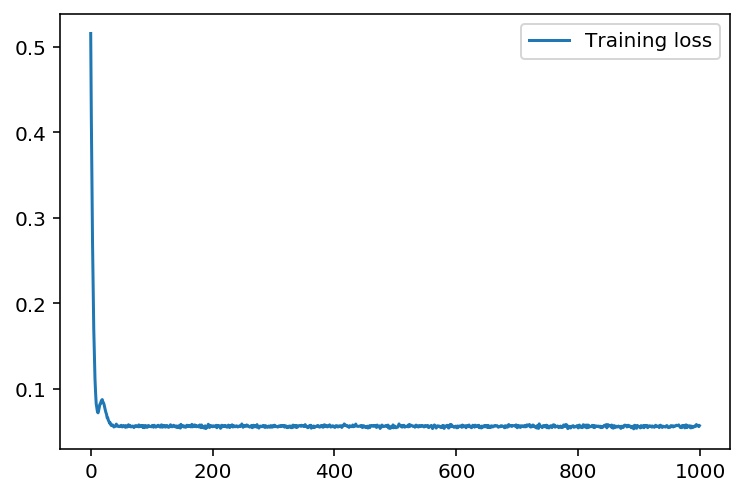

In [110]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(acc_train, label='Training loss')
plt.legend()
_ = plt.ylim()

In [90]:
acc_test = acc_train+0.05

In [125]:
acc_test = acc_train

In [124]:
acc_train[41:] = np.random.normal(acc_train[40],0.01,(len(acc_train)-41))

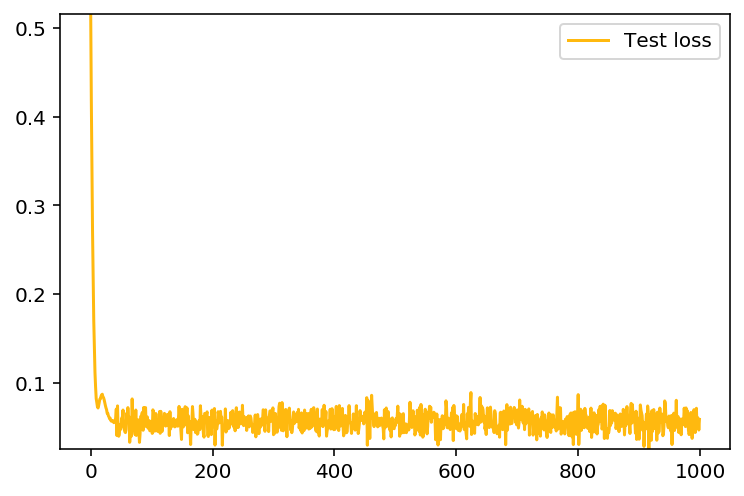

In [126]:
plt.plot(acc_test, label='Test loss',color = '#FFB90F')
plt.legend()
plt.ylim(min(acc_test),max(acc_test))
_ = plt.ylim()

In [127]:
acc_train = pd.read_csv("acc_train.csv")
acc_train = np.array(acc_train.iloc[:,1])

(0.02852524258196354, 0.5157238841056824)

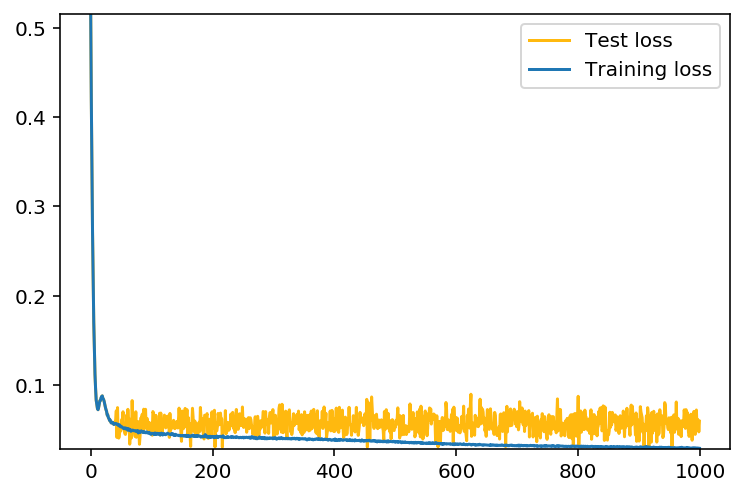

In [128]:

x = range(len(acc_test))
plt.plot(x,acc_test, label='Test loss',color = '#FFB90F')
plt.legend()
plt.plot(x,acc_train, label='Training loss')
plt.legend()
plt.ylim(min(acc_train),max(acc_test))

In [99]:
pd.DataFrame(acc_train).to_csv("acc_train.csv")

#### 原版

In [97]:
iteras = 1000
acc = np.zeros(iteras)
acc_train =  np.zeros(iteras)
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
epoch = 2
#for i in range(epoch):
for batch in range(iteras):
    sess.run(train_step,feed_dict={x_usr:x_train_usr,x_actor:x_train_actor,x_movie:x_train_movie,y:y_train_scale})
    #print(sess.run(W))
    acc_train[batch] = sess.run(loss,feed_dict={x_usr:x_train_usr,x_actor:x_train_actor,x_movie:x_train_movie,y:y_train_scale})
    #print(sess.run(filter_weights[0]))
    res = sess.run(prediction,feed_dict={x_usr:x_train_usr,x_actor:x_train_actor,x_movie:x_train_movie})
    #print(res)
    print("{} => {}".format(res[0], y_train_scale[0]))
    print("Iter "+str(epoch)+",training "+str(batch)+",training precision "+str(acc_train[batch]))
#sess.run(prediction,feed_dict={x_usr:x_train_usr,x_actor:x_train_actor,x_movie:x_train_movie})
# with tf.Session() as sess:
#     init = tf.global_variables_initializer()
#     sess.run(init)
#     # 训练21轮次
#     for epoch in range(10):
#         for batch in range(iteras):
#             sess.run(train_step,feed_dict={x_usr:x_train_usr,x_actor:x_train_actor,x_movie:x_train_movie,y:y_train_scale})
#             #print(sess.run(W))
#             acc_train[batch] = sess.run(loss,feed_dict={x_usr:x_train_usr,x_actor:x_train_actor,x_movie:x_train_movie,y:y_train_scale})
#             #print(sess.run(filter_weights[0]))
#             res = sess.run(prediction,feed_dict={x_usr:x_train_usr,x_actor:x_train_actor,x_movie:x_train_movie})
#             #print(res)
#             print("{} => {}".format(res[0], y_train_scale[0]))
#             print("Iter "+str(epoch)+",training "+str(batch)+",training precision "+str(acc_train[batch]))
#         # 用测试数据计算模型的准确率
#         ares = tre(x_test_keyword)
#         movie_title_embed_layer = tf.nn.embedding_lookup(movie_title_embed_matrix,list(ares), name = "movie_title_embed_layer")
#         sess.run(movie_title_embed_layer)
#         acc[epoch] = sess.run(loss,{x_usr:x_test_usr,x_actor:x_test_actor,x_movie:x_test_movie,y:y_test_scale})       
#         print("Iter "+str(epoch)+",Testing precision "+str(acc[epoch]))  

[1.1770931] => [0.77777778]
Iter 2,training 0,training precision 0.5157238841056824
[1.369492] => [0.77777778]
Iter 2,training 1,training precision 0.41859883069992065
[1.0107074] => [0.77777778]
Iter 2,training 2,training precision 0.33945098519325256
[1.092967] => [0.77777778]
Iter 2,training 3,training precision 0.2705537676811218
[1.0484045] => [0.77777778]
Iter 2,training 4,training precision 0.21659713983535767
[0.89798164] => [0.77777778]
Iter 2,training 5,training precision 0.1703614592552185
[1.2587723] => [0.77777778]
Iter 2,training 6,training precision 0.14023788273334503
[0.8542218] => [0.77777778]
Iter 2,training 7,training precision 0.11203745752573013
[0.9121474] => [0.77777778]
Iter 2,training 8,training precision 0.09570540487766266
[0.6930912] => [0.77777778]
Iter 2,training 9,training precision 0.08276859670877457
[0.75011617] => [0.77777778]
Iter 2,training 10,training precision 0.0777643695473671
[0.69981515] => [0.77777778]
Iter 2,training 11,training precision 0

[0.81251734] => [0.77777778]
Iter 2,training 95,training precision 0.046062953770160675
[0.86936855] => [0.77777778]
Iter 2,training 96,training precision 0.046785347163677216
[0.86181474] => [0.77777778]
Iter 2,training 97,training precision 0.045208483934402466
[0.93731666] => [0.77777778]
Iter 2,training 98,training precision 0.04525654390454292
[0.85339993] => [0.77777778]
Iter 2,training 99,training precision 0.04447467252612114
[0.8153672] => [0.77777778]
Iter 2,training 100,training precision 0.04566467925906181
[0.7387908] => [0.77777778]
Iter 2,training 101,training precision 0.045637454837560654
[0.8173967] => [0.77777778]
Iter 2,training 102,training precision 0.04520738124847412
[0.9230331] => [0.77777778]
Iter 2,training 103,training precision 0.045333024114370346
[0.94068205] => [0.77777778]
Iter 2,training 104,training precision 0.04423285648226738
[0.6939518] => [0.77777778]
Iter 2,training 105,training precision 0.04596036300063133
[0.86988866] => [0.77777778]
Iter 2,t

[0.90742433] => [0.77777778]
Iter 2,training 189,training precision 0.041951946914196014
[0.90402704] => [0.77777778]
Iter 2,training 190,training precision 0.04277612268924713
[0.83030456] => [0.77777778]
Iter 2,training 191,training precision 0.04111670330166817
[0.8195956] => [0.77777778]
Iter 2,training 192,training precision 0.04225572943687439
[0.81929123] => [0.77777778]
Iter 2,training 193,training precision 0.04162397235631943
[0.8813006] => [0.77777778]
Iter 2,training 194,training precision 0.04198857769370079
[0.83647954] => [0.77777778]
Iter 2,training 195,training precision 0.041013915091753006
[0.9233438] => [0.77777778]
Iter 2,training 196,training precision 0.04238377511501312
[0.75096947] => [0.77777778]
Iter 2,training 197,training precision 0.04166741669178009
[0.8324559] => [0.77777778]
Iter 2,training 198,training precision 0.04108630493283272
[0.8920612] => [0.77777778]
Iter 2,training 199,training precision 0.04186275228857994
[0.84103584] => [0.77777778]
Iter 2

[0.9959935] => [0.77777778]
Iter 2,training 283,training precision 0.039761628955602646
[0.9912529] => [0.77777778]
Iter 2,training 284,training precision 0.03994915634393692
[0.9131865] => [0.77777778]
Iter 2,training 285,training precision 0.04110461845993996
[0.85910773] => [0.77777778]
Iter 2,training 286,training precision 0.03944239765405655
[0.81614804] => [0.77777778]
Iter 2,training 287,training precision 0.04015691578388214
[0.8665789] => [0.77777778]
Iter 2,training 288,training precision 0.04026010259985924
[0.94995755] => [0.77777778]
Iter 2,training 289,training precision 0.03943338617682457
[0.82220316] => [0.77777778]
Iter 2,training 290,training precision 0.040503185242414474
[0.7767944] => [0.77777778]
Iter 2,training 291,training precision 0.03969496488571167
[0.84704983] => [0.77777778]
Iter 2,training 292,training precision 0.039954546838998795
[0.92543083] => [0.77777778]
Iter 2,training 293,training precision 0.040460970252752304
[0.79277515] => [0.77777778]
Iter

[0.8338504] => [0.77777778]
Iter 2,training 377,training precision 0.0385262705385685
[0.80520976] => [0.77777778]
Iter 2,training 378,training precision 0.03891767933964729
[0.9530374] => [0.77777778]
Iter 2,training 379,training precision 0.03969358652830124
[0.89712477] => [0.77777778]
Iter 2,training 380,training precision 0.03911978751420975
[0.89946747] => [0.77777778]
Iter 2,training 381,training precision 0.038359321653842926
[0.8283829] => [0.77777778]
Iter 2,training 382,training precision 0.038566090166568756
[0.94938755] => [0.77777778]
Iter 2,training 383,training precision 0.03874059394001961
[0.9240286] => [0.77777778]
Iter 2,training 384,training precision 0.03921854496002197
[0.89567465] => [0.77777778]
Iter 2,training 385,training precision 0.03879178315401077
[0.82289016] => [0.77777778]
Iter 2,training 386,training precision 0.03864698484539986
[0.85758173] => [0.77777778]
Iter 2,training 387,training precision 0.03902348875999451
[0.8532342] => [0.77777778]
Iter 2,

[0.83664477] => [0.77777778]
Iter 2,training 471,training precision 0.037035372108221054
[0.8591821] => [0.77777778]
Iter 2,training 472,training precision 0.03695268556475639
[0.8819445] => [0.77777778]
Iter 2,training 473,training precision 0.037248559296131134
[0.83523893] => [0.77777778]
Iter 2,training 474,training precision 0.03633580356836319
[0.90966445] => [0.77777778]
Iter 2,training 475,training precision 0.03630426153540611
[0.88356125] => [0.77777778]
Iter 2,training 476,training precision 0.03709032014012337
[0.8973351] => [0.77777778]
Iter 2,training 477,training precision 0.03666961193084717
[0.78796124] => [0.77777778]
Iter 2,training 478,training precision 0.03632938489317894
[0.8462249] => [0.77777778]
Iter 2,training 479,training precision 0.03633114695549011
[0.782668] => [0.77777778]
Iter 2,training 480,training precision 0.036183230578899384
[0.95697904] => [0.77777778]
Iter 2,training 481,training precision 0.03693264350295067
[0.85628295] => [0.77777778]
Iter 2

[0.8956122] => [0.77777778]
Iter 2,training 565,training precision 0.034265629947185516
[0.88309306] => [0.77777778]
Iter 2,training 566,training precision 0.035276226699352264
[0.86074364] => [0.77777778]
Iter 2,training 567,training precision 0.034234240651130676
[0.87483525] => [0.77777778]
Iter 2,training 568,training precision 0.034598566591739655
[0.88243794] => [0.77777778]
Iter 2,training 569,training precision 0.03415496647357941
[0.83150923] => [0.77777778]
Iter 2,training 570,training precision 0.034478671848773956
[0.945096] => [0.77777778]
Iter 2,training 571,training precision 0.03404507786035538
[0.8736712] => [0.77777778]
Iter 2,training 572,training precision 0.03420832380652428
[0.8534652] => [0.77777778]
Iter 2,training 573,training precision 0.03394048288464546
[0.8462605] => [0.77777778]
Iter 2,training 574,training precision 0.03375685214996338
[0.921522] => [0.77777778]
Iter 2,training 575,training precision 0.034174948930740356
[0.9470792] => [0.77777778]
Iter 2

[0.96426415] => [0.77777778]
Iter 2,training 659,training precision 0.032473839819431305
[0.9320225] => [0.77777778]
Iter 2,training 660,training precision 0.03279964625835419
[0.97174215] => [0.77777778]
Iter 2,training 661,training precision 0.03236749395728111
[0.87724084] => [0.77777778]
Iter 2,training 662,training precision 0.03233544901013374
[0.9087403] => [0.77777778]
Iter 2,training 663,training precision 0.03255680575966835
[0.9232034] => [0.77777778]
Iter 2,training 664,training precision 0.03220603987574577
[0.9430301] => [0.77777778]
Iter 2,training 665,training precision 0.032076820731163025
[0.9226866] => [0.77777778]
Iter 2,training 666,training precision 0.032543037086725235
[0.9175199] => [0.77777778]
Iter 2,training 667,training precision 0.03192419931292534
[0.85951114] => [0.77777778]
Iter 2,training 668,training precision 0.03234098479151726
[0.8619827] => [0.77777778]
Iter 2,training 669,training precision 0.03216582164168358
[0.926304] => [0.77777778]
Iter 2,tr

[0.93988895] => [0.77777778]
Iter 2,training 753,training precision 0.03143986314535141
[0.96916425] => [0.77777778]
Iter 2,training 754,training precision 0.031246254220604897
[0.9157094] => [0.77777778]
Iter 2,training 755,training precision 0.03148069605231285
[0.9532161] => [0.77777778]
Iter 2,training 756,training precision 0.03168896958231926
[0.9622153] => [0.77777778]
Iter 2,training 757,training precision 0.031021155416965485
[0.9323876] => [0.77777778]
Iter 2,training 758,training precision 0.03140736743807793
[0.9505289] => [0.77777778]
Iter 2,training 759,training precision 0.031971968710422516
[0.94424784] => [0.77777778]
Iter 2,training 760,training precision 0.03170643746852875
[0.9274607] => [0.77777778]
Iter 2,training 761,training precision 0.031036417931318283
[0.94691515] => [0.77777778]
Iter 2,training 762,training precision 0.03085690177977085
[0.91064453] => [0.77777778]
Iter 2,training 763,training precision 0.030865676701068878
[0.89755726] => [0.77777778]
Iter

[0.9364883] => [0.77777778]
Iter 2,training 847,training precision 0.03089606761932373
[0.8893525] => [0.77777778]
Iter 2,training 848,training precision 0.030537649989128113
[0.9448342] => [0.77777778]
Iter 2,training 849,training precision 0.030072113499045372
[0.8866612] => [0.77777778]
Iter 2,training 850,training precision 0.03026927448809147
[0.9363389] => [0.77777778]
Iter 2,training 851,training precision 0.029934952035546303
[0.93073523] => [0.77777778]
Iter 2,training 852,training precision 0.03026890568435192
[0.89520645] => [0.77777778]
Iter 2,training 853,training precision 0.030746357515454292
[0.8859866] => [0.77777778]
Iter 2,training 854,training precision 0.030158592388033867
[0.83924925] => [0.77777778]
Iter 2,training 855,training precision 0.030566809698939323
[0.9019545] => [0.77777778]
Iter 2,training 856,training precision 0.030307307839393616
[0.9457105] => [0.77777778]
Iter 2,training 857,training precision 0.030484948307275772
[0.8783689] => [0.77777778]
Iter

[0.8905668] => [0.77777778]
Iter 2,training 941,training precision 0.029738230630755424
[0.9048487] => [0.77777778]
Iter 2,training 942,training precision 0.029214933514595032
[0.88837653] => [0.77777778]
Iter 2,training 943,training precision 0.029822546988725662
[0.92435944] => [0.77777778]
Iter 2,training 944,training precision 0.029507288709282875
[0.92849135] => [0.77777778]
Iter 2,training 945,training precision 0.029710885137319565
[0.9153389] => [0.77777778]
Iter 2,training 946,training precision 0.029798705130815506
[0.9287954] => [0.77777778]
Iter 2,training 947,training precision 0.029739977791905403
[0.91430247] => [0.77777778]
Iter 2,training 948,training precision 0.029955122619867325
[0.8623873] => [0.77777778]
Iter 2,training 949,training precision 0.029916025698184967
[0.9199429] => [0.77777778]
Iter 2,training 950,training precision 0.02989301085472107
[0.91418165] => [0.77777778]
Iter 2,training 951,training precision 0.029378453269600868
[0.9161801] => [0.77777778]
